# Setup

In [1]:
# !pip install cloudant
# !conda install matplotlib
# !conda install pandas
# !conda install geopandas
# !conda install -c conda-forge folium

import configparser
from pathlib import Path
from cloudant.client import CouchDB
from cloudant.design_document import DesignDocument
from cloudant.view import View
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import display

# Current working directory
%cd .

# Global constants
DATADIR = Path("../geodata")
RESULTDIR = Path("../georesults")
GEOFILE = DATADIR / "aurin_datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggregated_pop_and_dwelling_counts_census_2016.json"
INVFILE = "../inventories/hosts_auto.ini"  # inventory file
DBGROUP = "couchdbgroup"  # db cluster
HOSTNAME = "thinkbox2 ansible_host"  # to retrieve IP address
USERNAME = "admin"
PASSWORD = "password"

C:\Users\84123\Google Drive\unimelb-cluster-and-cloud-computing-comp90024-2020-sm1\city_analytics\geo


# Geospatial data

,id,sa4_code_2016,population,dwelling,area_sqkm,sa4_name,state_name,geometry
0,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,101,218833,110671.0,5.189556e+04,Capital Region,New South Wales,"MULTIPOLYGON (((149.91630 -37.07400, 149.91620..."
1,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,102,327737,144386.0,1.681072e+03,Central Coast,New South Wales,"MULTIPOLYGON (((151.57270 -33.29070, 151.57140..."
2,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,103,206164,92830.0,7.029706e+04,Central West,New South Wales,"POLYGON ((150.14240 -32.34150, 150.16560 -32.3..."
3,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,104,136246,63414.0,1.322976e+04,Coffs Harbour - Grafton,New South Wales,"MULTIPOLYGON (((153.14540 -30.30180, 153.14530..."
4,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,105,113712,54295.0,3.393637e+05,Far West and Orana,New South Wales,"POLYGON ((148.67690 -29.50990, 148.80050 -29.5..."
...,...,...,...,...,...,...,...,...
84,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,604,109123,52340.0,2.252479e+04,West and North West,Tasmania,"MULTIPOLYGON (((144.65700 -40.37300, 144.65700..."
85,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,701,136683,55414.0,3.163906e+03,Darwin,Northern Territory,"MULTIPOLYGON (((130.87760 -12.55740, 130.87720..."
86,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,702,89360,35168.0,1.344930e+06,Northern Territory - Outback,Northern Territory,"MULTIPOLYGON (((130.16880 -11.55440, 130.16900..."
87,datasource-AU_Govt_ABS-UoM_AURIN_DB_3_sa4_aggr...,801,396698,163436.0,2.358172e+03,Australian Capital Territory,Australian Capital Territory,"POLYGON ((149.06240 -35.15920, 149.11550 -35.1..."


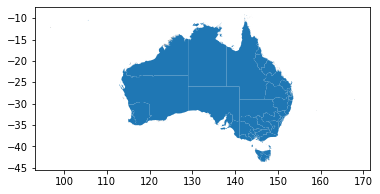

In [2]:
datageo = gpd.read_file(GEOFILE)
display(datageo)
datageo.plot()

# Tweet data

In [5]:
# Parse IP address from inventory file
config = configparser.ConfigParser()
config.read(INVFILE)
ip = config[DBGROUP][HOSTNAME]

In [6]:
def view_covid(name, partition_key="", area_col="area_code", var_col="variable", val_col="count", reduce=True, group=True, group_level=2,
               docid="", dbname="",
               ip="", username="admin", password="password", port=5984, connect=True):
    """
    View database
    """
    
    url = f"http://{ip}:{port}"
    client = CouchDB(username, password, url=url, connect=connect)
    db=client[dbname]  # database
    ddoc = DesignDocument(db, docid)
    
    # View
    view = View(ddoc, name, partition_key=partition_key)
    area_codes = []
    variables = []
    counts = []
    for row in view(reduce=reduce, group=group, group_level=group_level)['rows']:
        var, code = row["key"]  # variable, area code
        variables.append(var)
        area_codes.append(code)
        counts.append(row["value"])
    
    # Data
    data = pd.DataFrame({area_col: map(str, area_codes), var_col: variables, val_col: counts})  # area code in geo-map string stype
    
    return data

In [7]:
def geomap(geo_data, data, columns, key_on, fill_color="YlOrRd", nan_fill_color="white", fill_opacity=0.7, line_opacity=0.2,
           legend_name="value", highlight=True,
           fields=None, aliases=None, labels=True,
           location=(-23.6980, 133.8807), zoom_start=4, tiles="cartodbpositron"):
    """
    Create geospatial map
    Refer Folium documentation for parameters.
    """
    
    fields = fields or []
    aliases = aliases or []
    
    # Map
    m = folium.Map(location=location, zoom_start=zoom_start, tiles=tiles)
    
    # Layer
    choropleth = folium.Choropleth(
        geo_data=str(geo_data),
        data=data,
        columns=columns,
        key_on=key_on,
        fill_color=fill_color,
        nan_fill_color=nan_fill_color,
        fill_opacity=fill_opacity, 
        line_opacity=line_opacity,
        legend_name=legend_name,
        highlight=highlight
    ).add_to(m)
    
    # Pop-up display
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields, aliases=aliases, labels=labels)
    )

    folium.LayerControl().add_to(m)
    
    return m

## Covid

In [84]:
# View
dbname = "tweet-covid"
docid = "covid"
name = "sentiment_location"
partition_key = "name"
area_col="area_code"
var_col="variable"
val_col="count"
stat_col = "count"
data = view_covid(name, partition_key=partition_key, area_col=area_col, var_col=var_col, val_col=val_col,
                  docid=docid, dbname=dbname, ip=ip, username=USERNAME, password=PASSWORD)
var_levels = data[var_col].unique()  # variable levels
data = pd.pivot_table(data, values=val_col, index=[area_col], columns=[var_col], fill_value=0).reset_index()
data[stat_col] = data[var_levels].sum(axis=1)  # sum all variable levels
display(data)

# Map
outfile = RESULTDIR / "covid_sa4.html"  # output map
columns = [area_col, stat_col]
key_on = "feature.properties.sa4_code_2016"
fill_color = "YlOrRd"
legend_name = "No. of tweets"
fields = ["sa4_code_2016", "sa4_name"]
aliases = ["area code", "area name"]
labels = True
m = geomap(GEOFILE, data, columns, key_on, fill_color=fill_color, legend_name=legend_name, fields=fields, aliases=aliases, labels=labels)
display(m)
m.save(outfile.as_posix())

variable,area_code,negative,neutral,positive,count
0,101,311,664,696,1671
1,102,306,846,627,1779
2,103,515,1295,1017,2827
3,104,384,855,855,2094
4,105,711,1731,1460,3902
...,...,...,...,...,...
83,604,511,936,1093,2540
84,701,2129,5261,4515,11905
85,702,445,857,938,2240
86,801,20701,46749,49033,116483


## CovidSafe

In [85]:
# View
dbname = "tweet-covid-covidsafe"
docid = "covidsafe"
name = "sentiment_location"
partition_key = "name"
area_col="area_code"
var_col="variable"
val_col="count"
stat_col = "count"
data = view_covid(name, partition_key=partition_key, area_col=area_col, var_col=var_col, val_col=val_col,
                  docid=docid, dbname=dbname, ip=ip, username=USERNAME, password=PASSWORD)
var_levels = data[var_col].unique()  # variable levels
data = pd.pivot_table(data, values=val_col, index=[area_col], columns=[var_col], fill_value=0).reset_index()
data[stat_col] = data.positive / (data.positive + data.negative)  # positive tweet ratio
display(data)

# Map
outfile = RESULTDIR / "covidsafe_sentiment_sa4.html"  # output map
columns = [area_col, stat_col]
key_on = "feature.properties.sa4_code_2016"
fill_color = "RdYlGn"
legend_name = "Positivity rate"
fields = ["sa4_code_2016", "sa4_name"]
aliases = ["area code", "area name"]
labels = True
m = geomap(GEOFILE, data, columns, key_on, fill_color=fill_color, legend_name=legend_name, fields=fields, aliases=aliases, labels=labels)
display(m)
m.save(outfile.as_posix())

variable,area_code,negative,neutral,positive,count
0,101,9,14,8,0.470588
1,102,0,0,1,1.000000
2,103,5,3,4,0.444444
3,104,4,5,2,0.333333
4,105,1,11,4,0.800000
...,...,...,...,...,...
83,604,7,10,14,0.666667
84,701,5,19,8,0.615385
85,702,2,3,3,0.600000
86,801,117,326,308,0.724706


## Symptoms

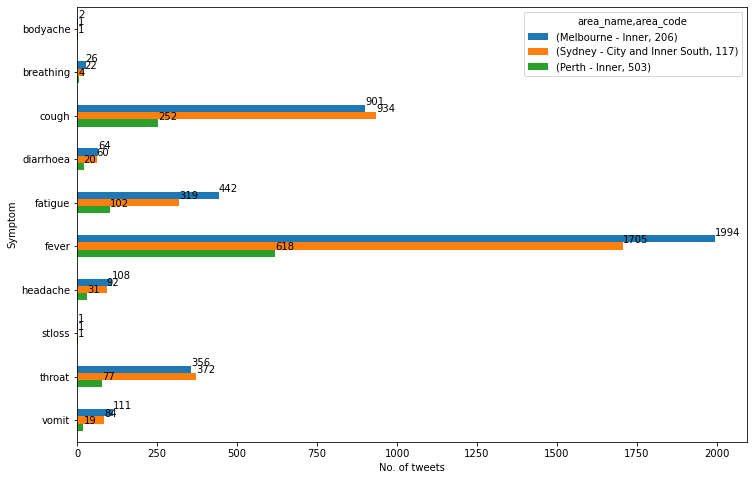

In [117]:
# View
dbname = "symptoms"
docid = "symptoms"
name = "symptoms_location"
partition_key = ""
area_col="area_code"
var_col="symptom"
val_col="count"
stat_col = "count"
data = view_covid(name, partition_key=partition_key, area_col=area_col, var_col=var_col, val_col=val_col,
                  docid=docid, dbname=dbname, ip=ip, username=USERNAME, password=PASSWORD)
data = data[pd.to_numeric(data[area_col]) >= 0]  # drop invalid area values
data = data.explode(var_col)  # unpack lists in column
var_levels = data[var_col].unique()  # variable levels
data = pd.pivot_table(data, values=val_col, index=[area_col], columns=[var_col], fill_value=0).reset_index()
data[stat_col] = data[var_levels].sum(axis=1)
# display(data)

# Tweet count by symptom for top areas
outfile = RESULTDIR / "symptoms_top_areas_sa4.png"  # output graph
ntop = 3
data_ntop = data.nlargest(ntop, "count")  # by area
data_ntop["area_name"] = datageo.set_index("sa4_code_2016").lookup(data_ntop.area_code, ["sa4_name"]*ntop)
data_ntop = data_ntop.set_index(["area_name", "area_code"])[var_levels]
data_trans = data_ntop.T  # transpose
ax = data_trans.plot.barh(rot=0, figsize=(12, 8))
ax.invert_yaxis()  # invert for largest on top
for p in ax.patches:
    ax.text(p.get_width(), p.get_y(), p.get_width())  # annotation
ax.set_xlabel("No. of tweets")
ax.set_ylabel("Symptom")
ax.get_figure().savefig(outfile, bbox_inches="tight")

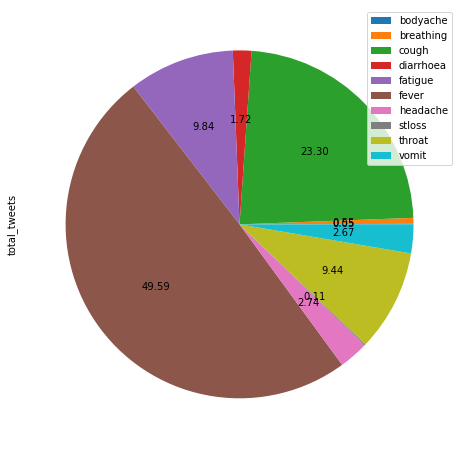

In [129]:
# Tweet count by symptom total
outfile = RESULTDIR / "symptoms_total_sa4.png"  # output graph
data_total = data[var_levels].sum().to_frame(name="total_tweets")  # total by symptom
ax = data_total.plot.pie(y="total_tweets", autopct="%.2f", labels=None, figsize=(8, 8))
ax.get_figure().savefig(outfile, bbox_inches="tight")

# References
Folium  
https://python-graph-gallery.com/292-choropleth-map-with-folium/  
https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/  
https://python-visualization.github.io/folium/modules.html#folium.features.Choropleth  
https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392  

Bokeh  
https://www.datacamp.com/community/tutorials/geospatial-data-python  
https://automating-gis-processes.github.io/CSC18/lessons/L5/interactive-map-bokeh.html  
https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9  
